In [1]:
# Import Libraries
import datetime as dt
import pandas as pd
import re
import numpy as np
import nltk
import regex as reg
import matplotlib.pyplot as plt

from twitterscraper import query_tweets
from sklearn.decomposition import LatentDirichletAllocation as LDA
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_multilabel_classification
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from bs4 import BeautifulSoup

%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')
%matplotlib inline

pd.set_option('display.max_colwidth',-1)
pd.set_option('display.max_rows', 1500)
pd.set_option('display.max_columns', 500)

INFO: {'User-Agent': 'Mozilla/5.0 (Windows; U; Windows NT 6.1; x64; fr; rv:1.9.2.13) Gecko/20101203 Firebird/3.6.13'}


## EXPLORATORY DATA ANALYSIS ALL LABELED TWEETS FIRE & HURRICANE

In [2]:
# Import data
df =pd.read_csv('../data/df8_SUPER.csv')

In [3]:
# Select the 3 columns that we are interested in.
df=df[['text','requesting_help','disaster']]

In [4]:
# Set X to the text column and y to the requesting_help column.
X = df['text']
y= df['requesting_help']

In [5]:
# Group by disaster and then requesting help to get the count of requesting help for each disaster.
df.groupby('disaster')['requesting_help'].value_counts()

disaster   requesting_help
fire       0                  427
           1                  75 
hurricane  0                  351
           1                  153
Name: requesting_help, dtype: int64

In [6]:
# Baseline calculation
df['requesting_help'].value_counts(normalize=True)

0    0.77336
1    0.22664
Name: requesting_help, dtype: float64

## MODELING

In [7]:
# Instantiate the train test split with stratify set to yes (keeps the ratio the same between train and test).
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, random_state=42)

## LOGISTIC REGRESSION WITH COUNT VECTORIZER

In [8]:
# Instantiate Pipline for Logistic Regression using Count Vectorizer
# Found this terrific website that explains the different solver options in LogisticRegression
# https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451
pipe_a = Pipeline([
    ('cvec_a', CountVectorizer()),
    ('lr_a', LogisticRegression(solver= 'lbfgs'))
])

params_a = {
    'cvec_a__max_features': [2000, 3000, 4000, 5000],
    'cvec_a__min_df': [2, 3],
    'cvec_a__max_df': [.9, .95],
    'cvec_a__ngram_range': [(1,1), (1,4)],
    'cvec_a__stop_words':['english', None]
}

gs_a = GridSearchCV(pipe_a,params_a, cv=5, n_jobs=3)
    
gs_a.fit(X_train, y_train)
    
print(f'Gridsearch with Count Vectorizer for training data is {gs_a.score(X_train, y_train)}')
print()
print(f'Gridsearch with Count Vectorizer for test data is {gs_a.score(X_test, y_test)}')

Gridsearch with Count Vectorizer for training data is 0.993368700265252

Gridsearch with Count Vectorizer for test data is 0.8928571428571429


In [9]:
# Lists the best parameters from the gridsearch.
gs_a.best_params_

{'cvec_a__max_df': 0.9,
 'cvec_a__max_features': 2000,
 'cvec_a__min_df': 2,
 'cvec_a__ngram_range': (1, 1),
 'cvec_a__stop_words': None}

## LOGISTIC REGRESSION WITH TFIDF VECTORIZER

In [11]:
# Sets up a pipeline for the Logistic Regression model using the Tfidf Vectorizer. Tfidf means
# Term Frequency Inverse Document Frequency. Next, set parameters for the gridsearch to search through.
pipe_b = Pipeline([
    ('tfid_b', TfidfVectorizer()),
    ('lr_b', LogisticRegression(solver= 'lbfgs'))
])

params_b = {
    'tfid_b__max_features': [2000, 3000, 4000, 5000],
    'tfid_b__min_df': [2, 3],
    'tfid_b__max_df': [.9, .95],
    'tfid_b__ngram_range': [(1,1), (1,4)],
    'tfid_b__stop_words':['english', None]
}

gs_b = GridSearchCV(pipe_b,params_b, cv=5, n_jobs=3)
    
gs_b.fit(X_train, y_train)
    
print(f'Gridsearch with TFIDF Vectorizer for training data is {gs_b.score(X_train, y_train)}')
print()
print(f'Gridsearch with TFIDF Vectorizer for test data is {gs_b.score(X_test, y_test)}')

Gridsearch with TFIDF Vectorizer for training data is 0.8952254641909815

Gridsearch with TFIDF Vectorizer for test data is 0.8650793650793651


In [12]:
# Lists the best hyper-parameters from the GridSearch.
gs_b.best_params_

{'tfid_b__max_df': 0.9,
 'tfid_b__max_features': 2000,
 'tfid_b__min_df': 3,
 'tfid_b__ngram_range': (1, 1),
 'tfid_b__stop_words': 'english'}

In [13]:
# Lists best parameters.
gs_b.best_estimator_

Pipeline(memory=None,
         steps=[('tfid_b',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.9, max_features=2000,
                                 min_df=3, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('lr_b',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_

In [14]:
# Create variable
gs_b_best = gs_b.best_estimator_

In [15]:
# pull coefficients for model
coefs = gs_b_best.named_steps['lr_b'].coef_[0]

In [16]:
# get feature names
features = gs_b_best.named_steps['tfid_b'].get_feature_names()

In [17]:
# create df
simple_df = pd.DataFrame({"features": features,
                         "coefficients": coefs,
                         "absolute_coefs": np.abs(coefs)})

In [18]:
# Print working directory
pwd

'/Users/Brian 1/Desktop/GA_12.10_1.04/shelter_status/code'

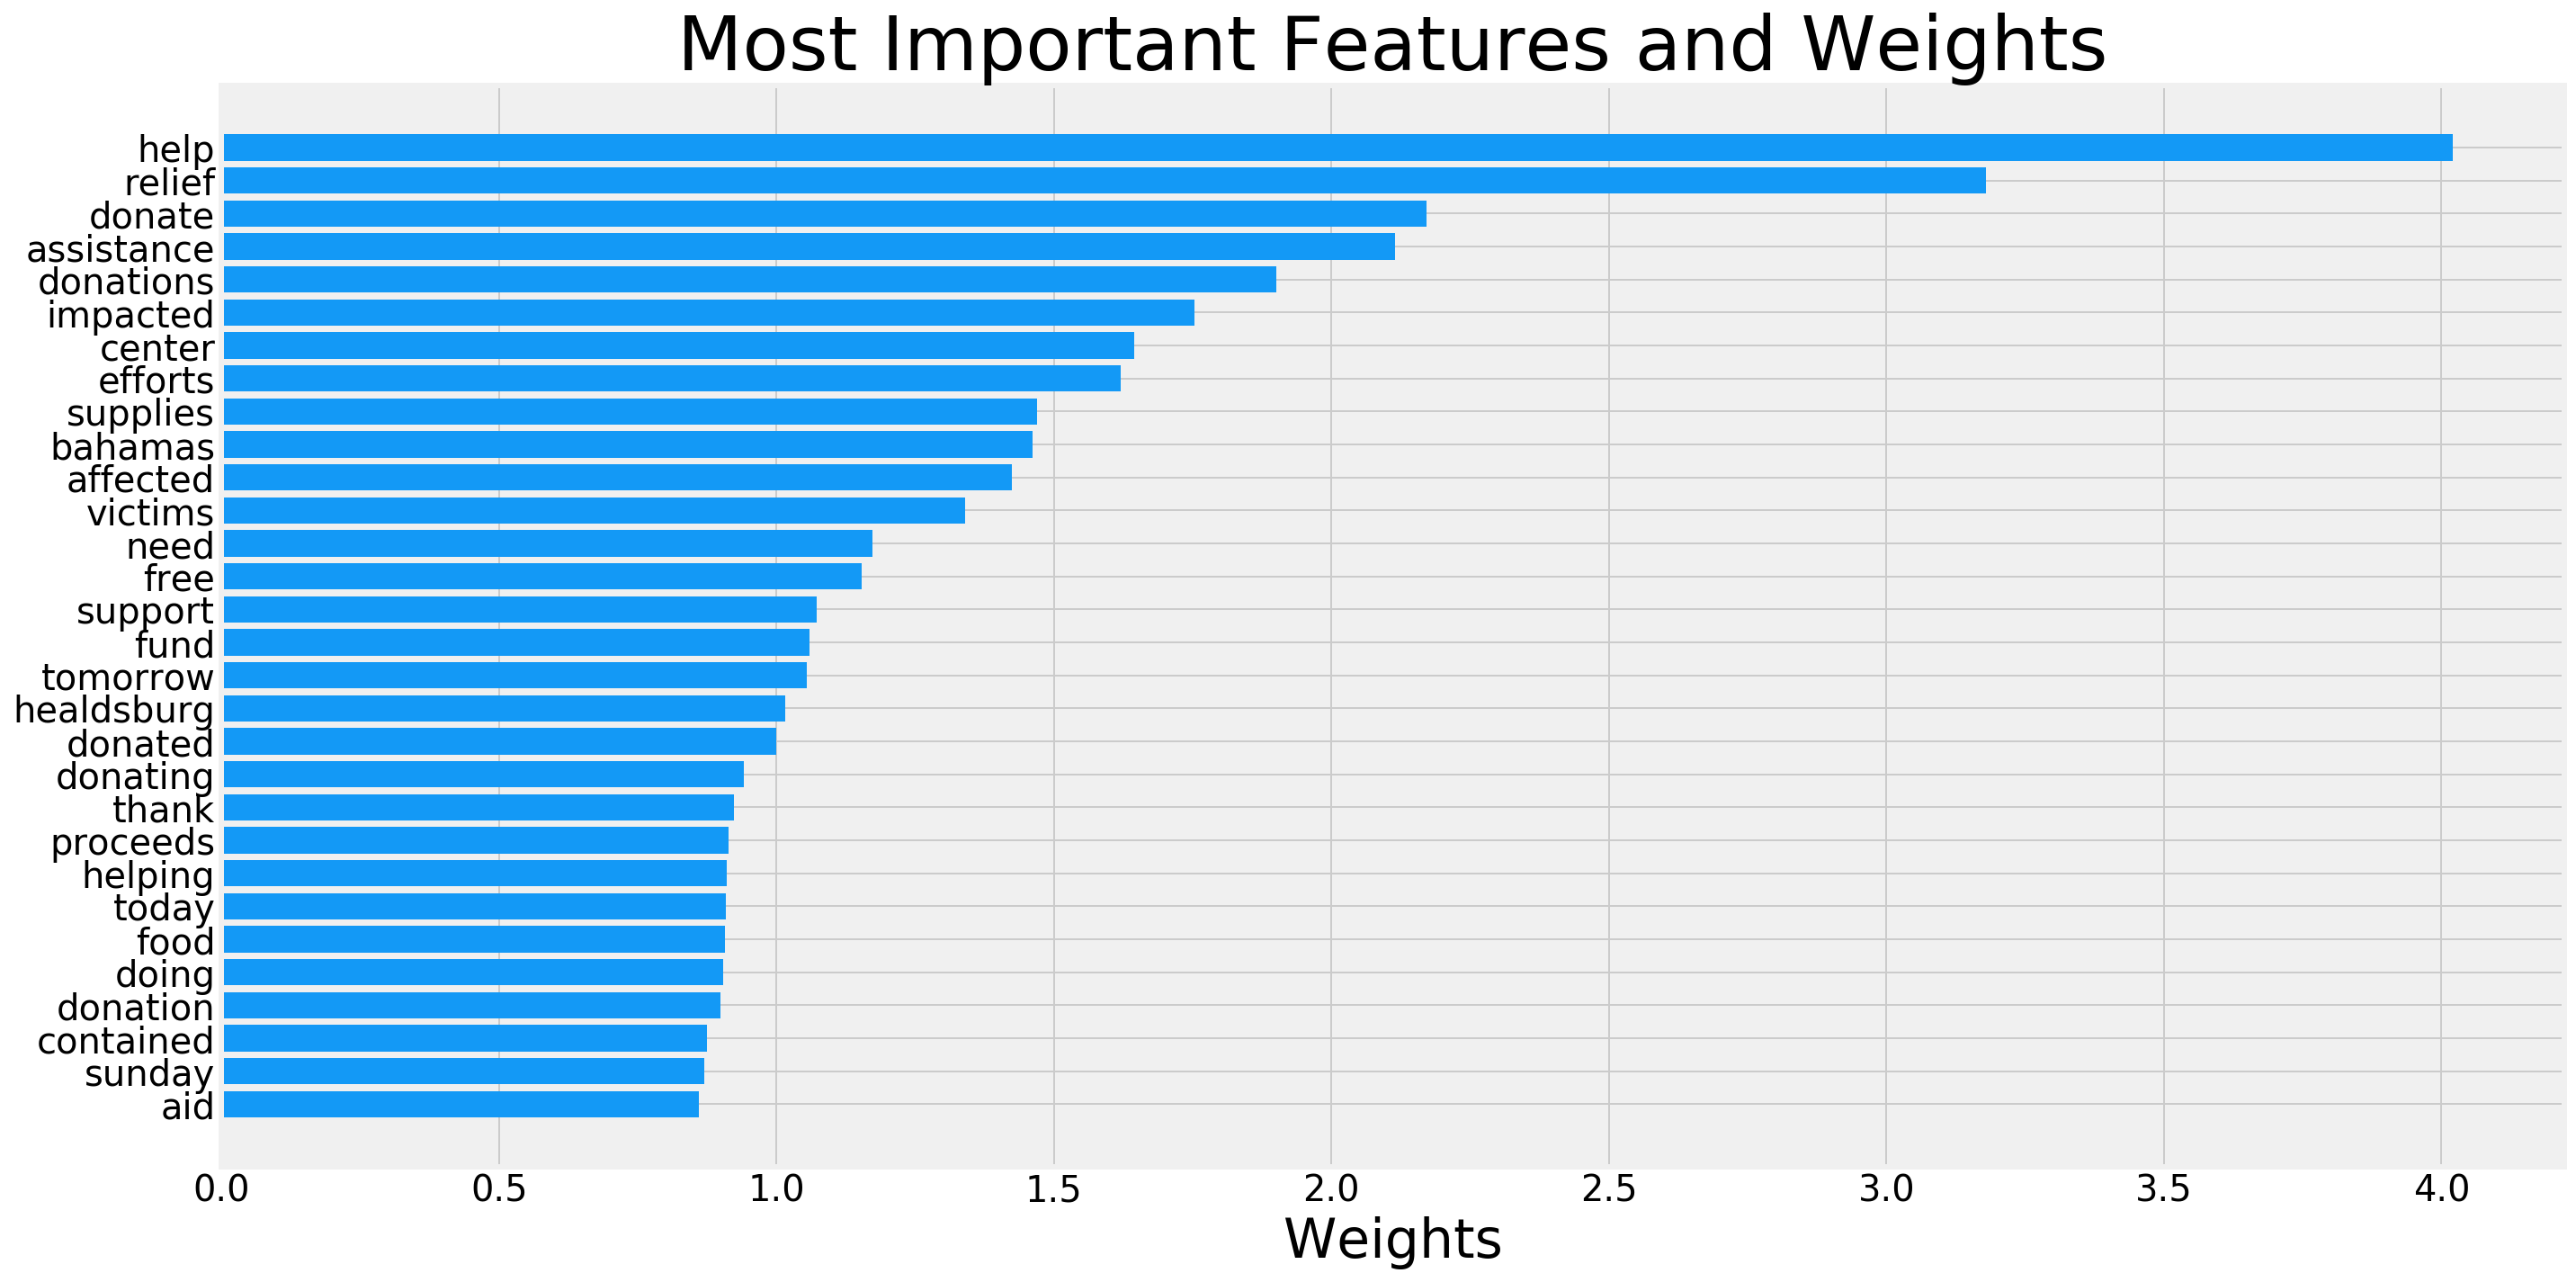

In [19]:
# graph in bar chart. This code is from Vivian.
beta_df = simple_df.sort_values("absolute_coefs", ascending = False)
beta_df = beta_df.reset_index(drop=True)
beta_df = beta_df.set_index('features')
beta_df = beta_df[beta_df['absolute_coefs'] != 0] #removes coefficients of 0
beta_df.head(20)
weights = beta_df['absolute_coefs'].head(30).sort_values()
labels = weights.index
plt.figure(figsize=(20,10))
plt.barh(labels, weights, color = "#1399F6")
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=30)
plt.title("Most Important Features and Weights", fontsize=42)
plt.tight_layout()
plt.savefig('../visuals/feature_coefs_lr.png')

In [20]:
# Lists the coefficients in descending order
simple_df.sort_values("absolute_coefs", ascending = False).head(20)

,features,coefficients,absolute_coefs
276,help,4.019596,4.019596
520,relief,3.179790,3.179790
153,donate,2.170999,2.170999
26,assistance,2.114942,2.114942
157,donations,1.901021,1.901021
311,impacted,1.753038,1.753038
77,center,1.645070,1.645070
172,efforts,1.620785,1.620785
627,supplies,1.469141,1.469141
34,bahamas,1.461151,1.461151


In [22]:
# Creates a dataframe for the predicted probability and the actual/true values.
pred_prob_b = [i[1] for i in gs_b.predict_proba(X_test)]

pred_df_b = pd.DataFrame({'true_values':y_test,
                         'pred_prob':pred_prob_b})

In [23]:
# Displays dataframe.
pred_df_b.head(3)

,true_values,pred_prob
905,1,0.47598
217,1,0.64535
84,1,0.49841


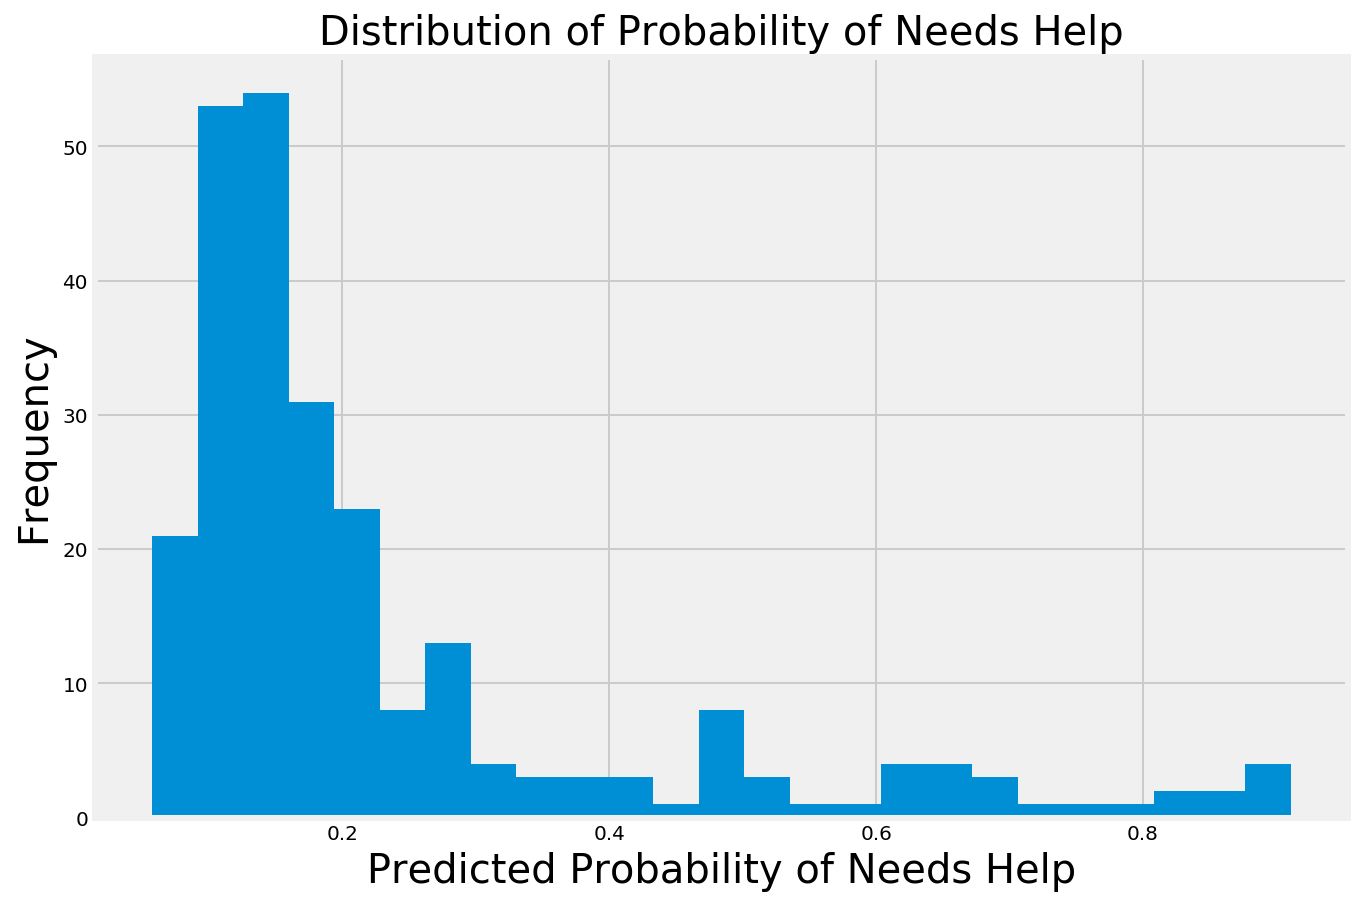

In [24]:
# Graph of the probability distribution of tweets that need help.
plt.figure(figsize= (10,7))

plt.hist(pred_df_b['pred_prob'], bins = 25)

plt.title('Distribution of Probability of Needs Help', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xlabel('Predicted Probability of Needs Help', fontsize=20);

## SVC WITH COUNT VECTORIZER - LINEAR KERNAL

In [25]:
# For hyperparameter C for the SVC searched through many values including 0.1, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 10, 20
# 100 and found that values between 2 and 3 were highest
# Tried all kernals linear, poly and sigmoid, but the default, rbf, was best.
pipe_c = Pipeline([
    ('cvec_c', CountVectorizer()),
    ('svc', SVC(C=2,gamma='scale', kernel='linear', probability=True))
])

params_c = {
    'cvec_c__max_features': [2000, 3000, 4000, 5000],
    'cvec_c__min_df': [2, 3],
    'cvec_c__max_df': [.9, .95],
    'cvec_c__ngram_range': [(1,1), (1,4)],
    'cvec_c__stop_words':['english', None]
}

gs_c = GridSearchCV(pipe_c,params_c, cv=5, n_jobs=3)
    
gs_c.fit(X_train, y_train)
    
print(f'Gridsearch with Count Vectorizer for training data is {gs_c.score(X_train, y_train)}')
print()
print(f'Gridsearch with Count Vectorizer for test data is {gs_c.score(X_test, y_test)}')

Gridsearch with Count Vectorizer for training data is 1.0

Gridsearch with Count Vectorizer for test data is 0.876984126984127


In [26]:
y_pred_c = gs_c.predict(X_test)

In [27]:
y_pred_c.shape

(252,)

# Predict on new tweets

In [28]:
# Imports the csv of all the combined tweets for the three disasters.
df_new = pd.read_csv("../Data/all_tweets_clean.csv")

In [29]:
# Removes the tweets that were manually labeled as 0 or 1 for requesting help. This is so we can make predictions
# on the unlabeled tweets.
df_new = df_new[df_new["requesting_help"].isnull()]

In [30]:
# Removes the tweets with the value of flood for disaster to avoid inconsistencies in how the data was collected.
# The flood tweets were pulled based on key words that were not utilized for the hurricane and fire tweets.
df_new = df_new[(df_new["disaster"]!= "floods")]

In [31]:
# Creates a new X1 variable that contains only the text column.
X1 = df_new['text']

In [32]:
# Creates dataframe.
pd.DataFrame(X1).head(3)

,text
485,he can t nuke the hurricane from poland
505,y all when i just left to go grab dinner like an hour ago the lines for the gas stations were so long that you couldn t get into a turn lane to go anywhere into those plazas i still gotta work tomorrow which means a lot of driving save some gas for ya girl
506,is about to fuck shit up like


In [33]:
# Sets a new y1 variable for the predictions of our model SVC with Count Vectorizer using the linear kernal.
y1 = gs_c.predict(X1)

In [34]:
# Adds the predictions to the df_new dataframe.
df_new["requesting_help"] = y1

In [35]:
# Displays the tweets that our model predicts are requesting help.
df_new[df_new["requesting_help"] ==1]

,text,requesting_help,disaster,languages
522,got all the supplies today but it was crazy out there time to prep the house,1,hurricane,en
542,thank you donna it s exhausting but i wouldn t live anywhere else,1,hurricane,en
557,see the thread below were taking precautions now our regularly scheduled streams will be on for tomorrow but well play by ear for next week it all depends on doing hurricane prep now,1,hurricane,en
562,kudos to for helping south floridian in preparation for everything was buy get free not just milk and items that need refrigeration pretty much everything,1,hurricane,en
570,as another hurricane approaches the will join forces with many democrats to urge tens of billions of dollars in relief but theyll still say a is too expensive,1,hurricane,en
...,...,...,...,...
60253,more artwork to benefit relief efforts in my hometown if you d like to color in some of these designs in person join us at this saturday from pm,1,fire,en
60307,weve got last minute foodie gift ideas that also help recovery efforts in ventura county pictured box o hand painted bonbons from ex voto chocolates confections,1,fire,en
60332,all evacuation orders lifted thank you thank you and all supporting agencies,1,fire,en
60334,wildwood ss generosity is helping so many this season hundreds of blankets for toys for victims of and caroling at the health care center,1,fire,en


In [75]:
model_predicts_needshelp = df_new[df_new["requesting_help"] ==1]

In [76]:
pd.to_csv('../data/model_predicts_needshelp')

AttributeError: module 'pandas' has no attribute 'to_csv'

In [36]:
dfc = pd.DataFrame(y_pred_c)
dfc[0].value_counts(normalize=True)

0    0.801587
1    0.198413
Name: 0, dtype: float64

In [37]:
pred_prob_c = [i[1] for i in gs_c.predict_proba(X_test)]

pred_df_c = pd.DataFrame({'true_values':y_test,
                         'pred_prob':pred_prob_c})

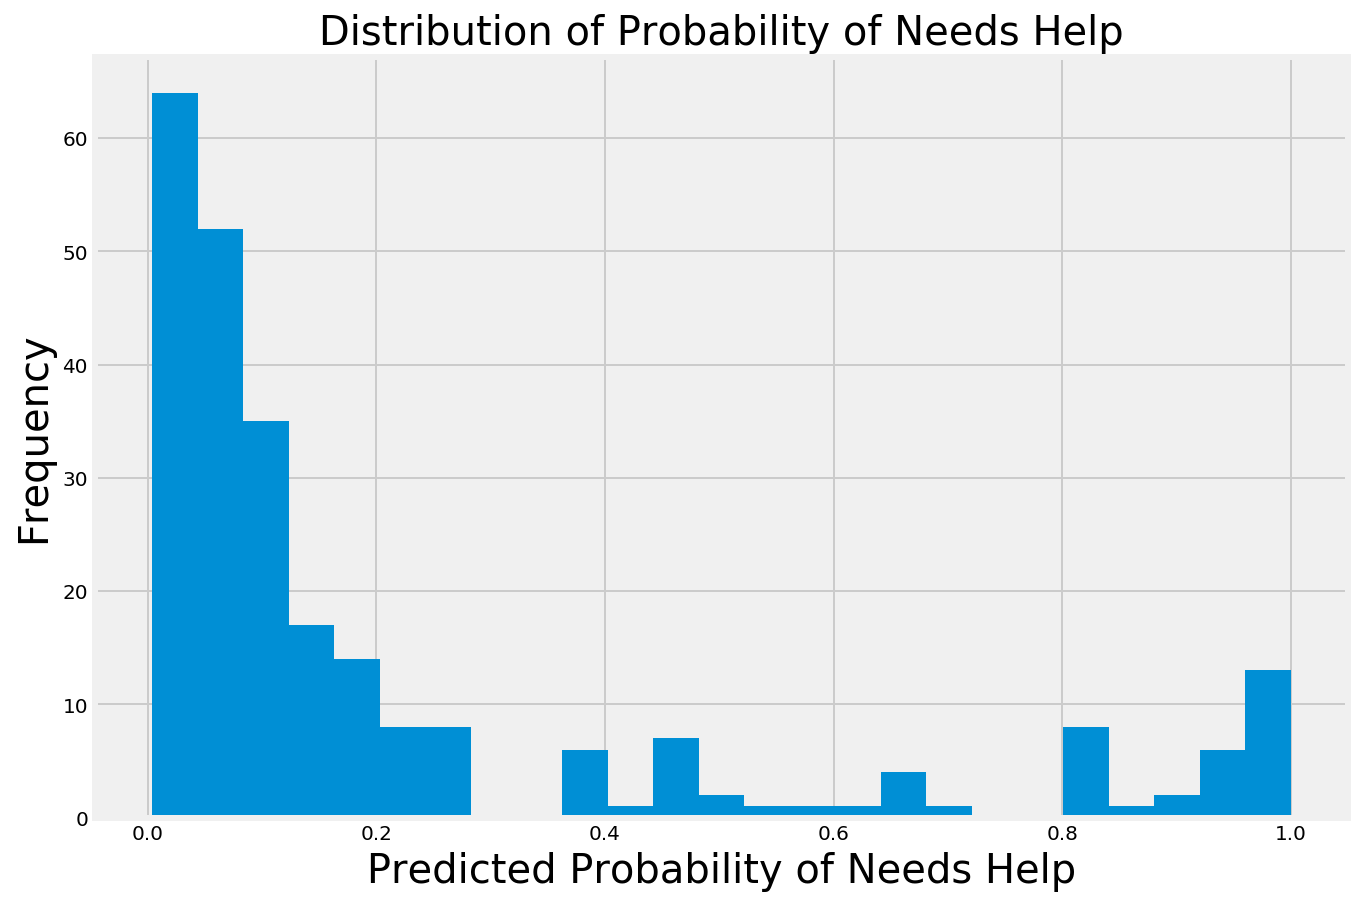

In [38]:
plt.figure(figsize= (10,7))

plt.hist(pred_df_c['pred_prob'], bins = 25)

plt.title('Distribution of Probability of Needs Help', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xlabel('Predicted Probability of Needs Help', fontsize=20);

In [39]:
# Measure performance based on accuracy.

accuracy_score(y_test, y_pred_c)

0.876984126984127

In [40]:
# Generate confusion matrix. From lesson 4.03
cm_c = confusion_matrix(y_test, # True values.
                 y_pred_c)  # Predicted values.
cm_c = pd.DataFrame(cm_c, columns=['pred no help', 'pred needs help'],
                   index=['actual no help', 'actual needs help'])
cm_c

,pred no help,pred needs help
actual no help,183,12
actual needs help,19,38


In [41]:
# Accuracy is All Correct/All Predictions which is(TP+TN)/(TP+FP+TN+FN)
(37+193)/(193+2+20+37)

0.9126984126984127

In [42]:
# Misclassification is All Incorrect/All Predictions or
# (FP+FN)/(TP+FP+TN+FN)
(20+2)/(193+2+20+37)

0.0873015873015873

In [43]:
# Sensitivity AKA Recall is True Positives/All Positives or (TP)/(TP+FN)
37/(37+20)

0.6491228070175439

In [44]:
# Specificity is True Negatives/All Negatives or TN/(TN+FP)
193/(193+20)

0.9061032863849765

In [45]:
# Precision is True Positives/Predicted Positives or TP/(TP+FP)
37/(37+2)

0.9487179487179487

In [46]:
# Type I errors or False Positives is 2
# Type II errors of False Negatives is 20.

In [47]:
# save the best model
#gs_full_model = gs_full.best_estimator_

In [48]:
gs_c.best_estimator_

Pipeline(memory=None,
         steps=[('cvec_c',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.9,
                                 max_features=2000, min_df=2,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('svc',
                 SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='linear', max_iter=-1, probability=True,
                     random_state=None, shrinking=True, tol=0.001,
                   

In [49]:
gs_c_best = gs_c.best_estimator_

In [50]:

# get feature names
features = gs_b_best.named_steps['tfid_b'].get_feature_names()

In [51]:
# create df
simple_df = pd.DataFrame({"features": features,
                         "coefficients": coefs,
                         "absolute_coefs": np.abs(coefs)})

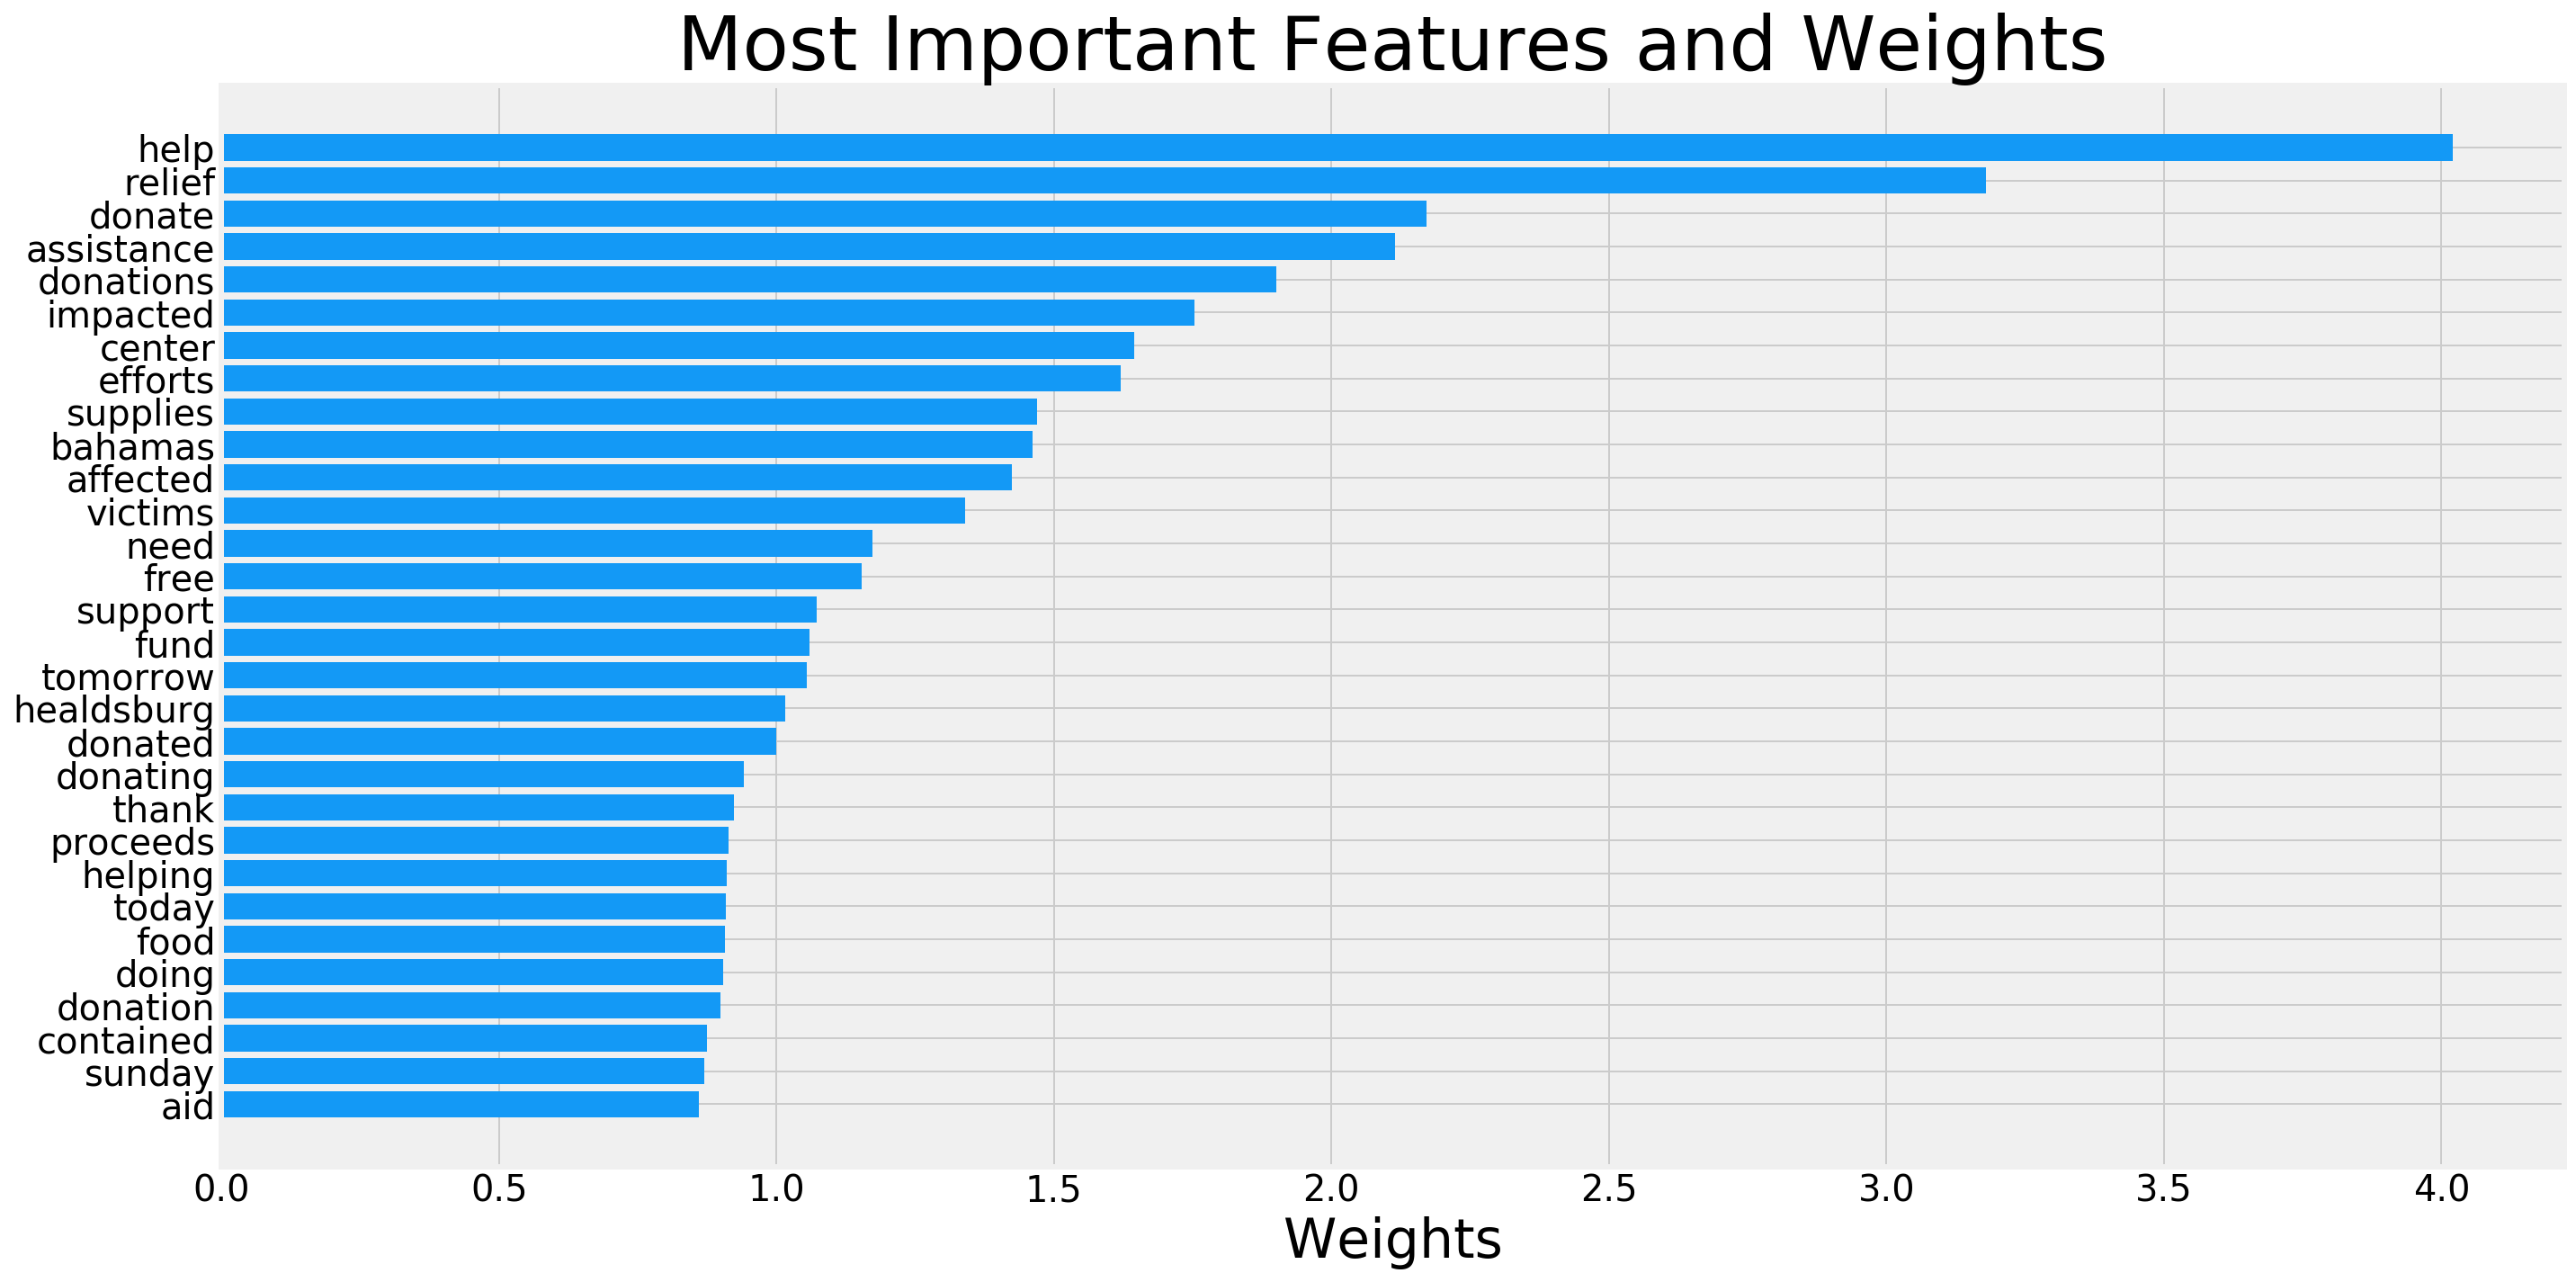

In [52]:
# graph in bar chart
beta_df = simple_df.sort_values("absolute_coefs", ascending = False)
beta_df = beta_df.reset_index(drop=True)
beta_df = beta_df.set_index('features')
beta_df = beta_df[beta_df['absolute_coefs'] != 0] #removes coefficients of 0
beta_df.head(20)
weights = beta_df['absolute_coefs'].head(30).sort_values()
labels = weights.index
plt.figure(figsize=(20,10))
plt.barh(labels, weights, color = "#1399F6")
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=30)
plt.title("Most Important Features and Weights", fontsize=42)
plt.tight_layout()
plt.savefig('../visuals/feature_coefs_lr.png')

## SVC WITH COUNT VECTORIZOR AND RBF KERNAL- BEST PERFORMING MODEL

In [53]:
# For hyperparameter C for the SVC searched through many values including 0.1, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 10, 20
# 100 and found that values between 2 and 3 were highest
# Tried all kernals linear, poly and sigmoid, but the default, rbf, was best.
pipe_r = Pipeline([
    ('cvec_r', CountVectorizer()),
    ('svc', SVC(C=2,gamma='scale', kernel='rbf', probability=True))
])

params_r = {
    'cvec_r__max_features': [2000, 3000, 4000, 5000],
    'cvec_r__min_df': [2, 3],
    'cvec_r__max_df': [.9, .95],
    'cvec_r__ngram_range': [(1,1), (1,4)],
    'cvec_r__stop_words':['english', None]
}

gs_r = GridSearchCV(pipe_r,params_r, cv=5, n_jobs=3)
    
gs_r.fit(X_train, y_train)
    
print(f'Gridsearch with Count Vectorizer for training data is {gs_r.score(X_train, y_train)}')
print()
print(f'Gridsearch with Count Vectorizer for test data is {gs_r.score(X_test, y_test)}')

Gridsearch with Count Vectorizer for training data is 0.9960212201591512

Gridsearch with Count Vectorizer for test data is 0.9126984126984127


In [54]:
y2 = gs_r.predict(X1)

In [55]:
y2_df = pd.DataFrame(y2)

In [56]:
y2_df

,0
0,0
1,0
2,0
3,0
4,0
...,...
58482,0
58483,0
58484,0
58485,0


In [57]:
y2_df[0].value_counts()

0    52219
1    6268 
Name: 0, dtype: int64

## SVC WITH TFIDF VECTORIZER SECOND BEST MODEL

In [58]:
pipe_d = Pipeline([
    ('tfid_d', TfidfVectorizer()),
    ('svc', SVC(C=2,gamma='scale'))
])

params_d = {
    'tfid_d__max_features': [2000, 3000, 4000, 5000],
    'tfid_d__min_df': [2, 3],
    'tfid_d__max_df': [.9, .95],
    'tfid_d__ngram_range': [(1,1), (1,4)],
    'tfid_d__stop_words':['english', None]
}

gs_d = GridSearchCV(pipe_d,params_d, cv=5, n_jobs=3)
    
gs_d.fit(X_train, y_train)
    
print(f'Gridsearch with Count Vectorizer for training data is {gs_d.score(X_train, y_train)}')
print()
print(f'Gridsearch with Count Vectorizer for test data is {gs_d.score(X_test, y_test)}')

Gridsearch with Count Vectorizer for training data is 1.0

Gridsearch with Count Vectorizer for test data is 0.9087301587301587


In [59]:
y_pred_d = gs_d.predict(X_test)

In [60]:
# Measure performance based on accuracy.
accuracy_score(y_test, y_pred_d)

0.9087301587301587

In [61]:
# Generate confusion matrix. From lesson 4.03
cm_d = confusion_matrix(y_test, # True values.
                 y_pred_d)  # Predicted values.
cm_d = pd.DataFrame(cm_d, columns=['pred no help', 'pred needs help'],
                   index=['actual no help', 'actual needs help'])
cm_d

,pred no help,pred needs help
actual no help,191,4
actual needs help,19,38


In [62]:
# Got code from Vivian which Dan Kim shared in class!
def nice_conmat(y_test, y_pred_d, classes):
    conmat = confusion_matrix(y_test, y_pred_d)
    print(f'Accuracy Score: {accuracy_score(y_test, y_pred_d)}')
    return pd.DataFrame(conmat, columns=['Predicted ' +class_ for class_ in classes], \
                index=['Actual '+ class_ for class_ in classes])

In [63]:
nice_conmat(y_test, y_pred_d, ['No Help Needed', 'Needs Help'])

Accuracy Score: 0.9087301587301587


,Predicted No Help Needed,Predicted Needs Help
Actual No Help Needed,191,4
Actual Needs Help,19,38


In [64]:
# Accuracy is All Correct/All Predictions which is(TP+TN)/(TP+FP+TN+FN)
(38+191)/(252)

0.9087301587301587

In [65]:
# Misclassification is All Incorrect/All Predictions or
# (FP+FN)/(TP+FP+TN+FN)
(19+4)/252

0.09126984126984126

In [66]:
# Sensitivity AKA Recall is True Positives/All Positives or (TP)/(TP+FN)
38/(38+19)

0.6666666666666666

In [67]:
# Specificity is True Negatives/All Negatives or TN/(TN+FP)
191/(191+19)

0.9095238095238095

In [68]:
# Precision is True Positives/Predicted Positives or TP/(TP+FP)
38/(38+4)

0.9047619047619048

In [69]:
# Type I errors or False Positives is 4
# Type II errors of False Negatives is 19.

## MULTINOMIAL NAIVE BAYES THIRD BEST MODEL (VERY CLOSE TO SECOND)

In [70]:
pipe_e = Pipeline([
    ('cvec_e', CountVectorizer()),
    ('mnb', MultinomialNB())
])

params_e = {}

gs_e = GridSearchCV(pipe_e, params_e, cv=5, n_jobs=3)

gs_e.fit(X_train, y_train)

print(f'Gridsearch with Count Vectorizer for training data is {gs_e.score(X_train, y_train)}')
print(f'Gridsearch with Count Vectorizer for test data is {gs_e.score(X_test, y_test)}')

Gridsearch with Count Vectorizer for training data is 0.980106100795756
Gridsearch with Count Vectorizer for test data is 0.9007936507936508


In [71]:
X_train.shape

(754,)

## GAUSSIAN NAIVE BAYES

In [72]:
pipe_f = Pipeline([
    ('tfid_e', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

params_f = {}

gs_f = GridSearchCV(pipe_f, params_f, cv=5, n_jobs=3)

gs_f.fit(X_train, y_train)

print(f'Gridsearch with Tfidf Vectorizer for training data is {gs_f.score(X_train, y_train)}')
print(f'Gridsearch with Tfidf Vectorizer for training data is {gs_f.score(X_train, y_train)}')

Gridsearch with Tfidf Vectorizer for training data is 0.8355437665782494
Gridsearch with Tfidf Vectorizer for training data is 0.8355437665782494


In [73]:
y_pred_f = gs_f.predict(X_test)

In [74]:
# Measure performance based on accuracy.

accuracy_score(y_test, y_pred_f)

0.7936507936507936